## Download and Install Required Libraries

Github: [source codes](https://github.com/qubvel/segmentation_models.pytorch/blob/master/README.md)

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=164d3c62df506e47ab31eb343781c4a4741e69d2bcc53a2a499ef4a81cb96b0d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d1795e48cdf477254e1f9e0e6a829d20b3530e49b53519ed98986b333bfae5a0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
!nvidia-smi

Tue Jul 11 10:43:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set Global Seed

In [4]:
import random

random.seed(13204942)

## Mount Google Drive to access your data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_path = '/content/drive/MyDrive/Ultrasound_project/'

### Data Preparation

In [7]:
import cv2
import os
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
TRAIN_IMG_DIR = root_path + "HC18_UNet_orig/train_images/"
TRAIN_MASK_DIR = root_path + "HC18_UNet_orig/train_masks/"

VAL_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
VAL_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"

In [9]:
# process original mask to binary mask
def preprocess_mask(mask):
  #mask = mask.astype(np.float32)
  #mask[mask == 2.0] = 0.0
  #mask[(mask == 1.0) | (mask == 3.0)] = 1.0

  # we need to use sigmoid
  mask[mask == 255.0] = 1.0

  mask = np.stack([mask], axis=-1).astype('float')
  return mask

In [25]:
# Dataset class
class HeadDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_Annotation.png"))
    #image = np.array(Image.open(img_path).convert("RGB"))
    #mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype('float32')
    #mask = preprocess_mask(mask)
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [10]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
# Lets look at data we have

dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=None,
    )

In [ ]:
index = random.sample(range(1, len(dataset)), 2)
print(index)

[748, 116]


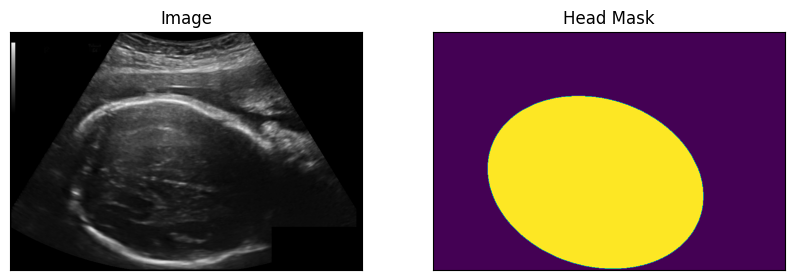

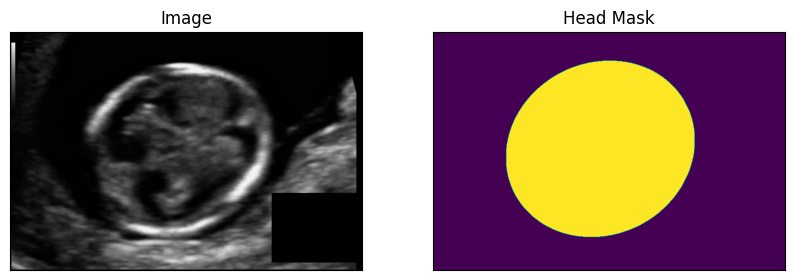

In [ ]:
for i in index:
  image, mask = dataset[i] # get some sample
  visualize(
      image=image,
      head_mask=mask.squeeze(),
  )

In [ ]:
print(image.shape, mask.shape)

(540, 800, 3) (540, 800)


In [10]:
# get Train/Validation DataLoaders from Dataset class
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HeadDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = HeadDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

## Build Model

We are using an existing Pytorch library, Segmentation Models (SMP), with Neural Networks for Image
Segmentation. The official library document is [here](https://smp.readthedocs.io/).

P. Iakubovskii, “Segmentation models pytorch,” 2019.

*@misc{Iakubovskii:2019,
  Author = {Pavel Iakubovskii},
  Title = {Segmentation Models Pytorch},
  Year = {2019},
  Publisher = {GitHub},
  Journal = {GitHub repository},
  Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
}*

**Avaliable architectures:**
 - Unet [[paper](https://arxiv.org/abs/1505.04597)] [[docs](https://smp.readthedocs.io/en/latest/models.html#unet)]
 - Unet++ [[paper](https://arxiv.org/pdf/1807.10165.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id2)]
 - MAnet [[paper](https://ieeexplore.ieee.org/abstract/document/9201310)] [[docs](https://smp.readthedocs.io/en/latest/models.html#manet)]
 - Linknet [[paper](https://arxiv.org/abs/1707.03718)] [[docs](https://smp.readthedocs.io/en/latest/models.html#linknet)]
 - FPN [[paper](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)] [[docs](https://smp.readthedocs.io/en/latest/models.html#fpn)]
 - PSPNet [[paper](https://arxiv.org/abs/1612.01105)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pspnet)]
 - PAN [[paper](https://arxiv.org/abs/1805.10180)] [[docs](https://smp.readthedocs.io/en/latest/models.html#pan)]
 - DeepLabV3 [[paper](https://arxiv.org/abs/1706.05587)] [[docs](https://smp.readthedocs.io/en/latest/models.html#deeplabv3)]
 - DeepLabV3+ [[paper](https://arxiv.org/abs/1802.02611)] [[docs](https://smp.readthedocs.io/en/latest/models.html#id9)]

**Available Encoders:**
The following is a list of supported encoders in the SMP library. The selected encoder and its pre-trained weights (encoder_name and encoder_weights parameters) are shown as below.

* ResNet

| Encoder   | Weights               | Params, M |
| --------- | --------------------- | --------- |
| resnet18  | imagenet / ssl / swsl | 11M       |
| resnet50  | imagenet / ssl / swsl | 23M       |
| resnet101 | imagenet              | 42M       |
| resnet152 | imagenet              | 58M       |

* Densenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|densenet121                     |imagenet                        |6M                              |
|densenet169                     |imagenet                        |12M                             |
|densenet201                     |imagenet                        |18M                             |
|densenet161                     |imagenet                        |26M                             |

* Inception

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|inceptionresnetv2               |imagenet /  imagenet+background |54M                             |
|inceptionv4                     |imagenet /  imagenet+background |41M                             |
|xception                        |imagenet                        |22M                             |

* Mobilenet

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|mobilenet_v2                    |imagenet                        |2M                              |

* VGG

|Encoder                         |Weights                         |Params, M                       |
|--------------------------------|:------------------------------:|:------------------------------:|
|vgg11                           |imagenet                        |9M                              |
|vgg13                           |imagenet                        |9M                              |
|vgg16                           |imagenet                        |14M                             |
|vgg19                           |imagenet                        |20M                             |

In [11]:
import os
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [12]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

Set pre-trained encoders. **Choose one ENCODER from above encoders list to build your model !**

In [16]:
# if encoder needs to be frozen, set below flag = True
freeze_flag = True

In [13]:
ENCODER = 'mobilenet_v2'

ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['head'] # a binary classification problem to classify each pixel into one of the two classes, Class 1: Head or Class 2: Not Head
#ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

AUX_PARAMS=dict(
    pooling='max',           # one of 'avg', 'max'
    activation='sigmoid',    # activation function, default is None
    classes=1,               # define number of output labels
)

**Select one of below architectures to build your model !**

Build a deep learning architecture using library segmentation_models_pytorch, and then load pre-trained CNN to encoders inside the architecture.

#### U-Net

<img src=https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png width="640">

In [14]:
# create segmentation model with pretrained encoder
unet_model = smp.Unet(
    encoder_name=ENCODER,
    #encoder_weights=ENCODER_WEIGHTS,  # pre-training on ImageNet
    encoder_weights=None,  # random initialization
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=None
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
model = unet_model

if freeze_flag:
  model_name = f'unet_frozen_{ENCODER}'
else:
  model_name = f'unet_{ENCODER}'

In [19]:
if freeze_flag:
  for param in model.encoder.parameters():
    param.requires_grad = False

In [18]:
model.classification_head = None

In [19]:
print(model)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

**Freeze Decoder layers partially**

In [22]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [ ]:
if freeze_flag:
  # freeze all layers except the bottleneck
  '''
  for param in model.encoder.model.blocks[0].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[1].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[2].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[3].parameters():
    param.requires_grad = False

  for param in model.encoder.model.blocks[4].parameters():
    param.requires_grad = False
  '''
  '''
  for param in model.decoder.blocks[0].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[1].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[2].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[3].parameters():
    param.requires_grad = False

  for param in model.decoder.blocks[4].parameters():
    param.requires_grad = False

  for param in model.segmentation_head.parameters():
    param.requires_grad = False
  '''

In [20]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [21]:
from torchsummary import summary

print(summary(model, (3, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

## Training Model

In [22]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 10
NUM_EPOCHS = 20 # 5 warm-up
NUM_WORKERS = 2
# UNet DeepLab3+
#IMAGE_HEIGHT = 240  # 540 originally
#IMAGE_WIDTH = 240  # 800 originally
# FPN
IMAGE_HEIGHT = 512  # 540 originally
IMAGE_WIDTH = 512  # 800 originally

PIN_MEMORY = True
LOAD_MODEL = False

In [26]:
DEVICE

'cuda'

#### Set-up Data Loader

In [23]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [26]:
# split train, validation
full_dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    )

In [27]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

### Split Training Set

In [ ]:
len(train_ds)

799

In [ ]:
#split_train_size_10 = int(0.1 * len(train_ds))
#split_train_size_30 = int(0.3 * len(train_ds))
#split_train_size_50 = int(0.5 * len(train_ds))

#### Save Dataset

In [33]:
save_path = root_path + 'train_data_split/'

In [ ]:
#train_length = split_train_size_10
#train_length = split_train_size_30
train_length = split_train_size_50

In [ ]:
remaining_size = len(train_ds) - train_length
train_ds, _ = torch.utils.data.random_split(train_ds, [train_length, remaining_size])

In [ ]:
#torch.save(train_ds, save_path + 'split_train_size_10.pt')
#torch.save(train_ds, save_path + 'split_train_size_30.pt')
torch.save(train_ds, save_path + 'split_train_size_50.pt')

#### Load Dataset

In [ ]:
print(save_path + 'split_train_size_50.pt')
#train_ds = torch.load(save_path + 'split_train_size_10.pt')
#train_ds = torch.load(save_path + 'split_train_size_30.pt')
train_ds = torch.load(save_path + 'split_train_size_50.pt')

'/content/drive/MyDrive/Ultrasound_project/train_data_split/split_train_size_50.pt'

In [ ]:
print(f'The lenght of train dataset: {len(train_ds)}')

The lenght of train dataset: 399


#### Start DataLoader

In [ ]:
print(len(train_ds))
print(len(val_ds))

799
200


In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
print(len(train_loader))
print(len(val_loader))

80
20


In [ ]:
'''
train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
    )
'''

#### Create a Function for Training

In [28]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [35]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  losses = []

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      #loss = loss_fn(predictions[0], targets)
      loss = loss_fn(predictions, targets)
      losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return losses #loss.item()

In [29]:
def check_accuracy(loader, model, loss_fn, pix_acc, dice, iou, device="cuda", is_train=True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    iou_val = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            prediction = model(x)
            loss = loss_fn(prediction, y.float())
            losses.append(loss.item())

            #preds = preds[0]
            preds = torch.sigmoid(prediction)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
                )
            iou_val += (preds * y).sum() / (
                (preds + y).sum() - (preds * y).sum() + 1e-8
                )

        p_acc = num_correct/num_pixels*100
        print(f"Got {num_correct}/{num_pixels} with acc {p_acc:.4f}")
        pix_acc.append(p_acc.item())

        d_score = dice_score * 100 / len(loader)
        print(f"Dice score: {d_score:.4f}")
        dice.append(d_score.item())

        iou_score = iou_val * 100 / len(loader)
        print(f"mIoU: {iou_score:.4f}")
        iou.append(iou_score.item())

    print(f"Got validation loss: {np.mean(losses):.6f}")

    if is_train:
      model.train()

    return pix_acc, dice, iou, losses

#### Start Training

In [30]:
model = model.to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
best_loss = 1.0

pix_acc = []
dice = []
miou = []
ep_loss = []
tr_loss_global = []
val_loss_global = []

for epoch in range(NUM_EPOCHS):
  print(f"{epoch}:")
  current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
  tr_loss_global += current_loss
  print(".\n")
  print(f"Got training loss: {np.mean(current_loss):.6f}")

  # check accuracy
  pix_acc, dice_score, m_iou, ep_loss = check_accuracy(val_loader, model, loss_fn, pix_acc, dice, miou, device=DEVICE)
  val_loss_global += ep_loss

  # print some examples to a folder
  #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

0:


100%|██████████| 80/80 [02:44<00:00,  2.06s/it, loss=0.357]

.

Got training loss: 0.446614


Got validation loss: 0.418041
Got 41400778/52428800 with acc 78.9657
Dice score: 53.6755
mIoU: 36.8412
1:


100%|██████████| 80/80 [00:22<00:00,  3.54it/s, loss=0.32]

.

Got training loss: 0.308734


Got validation loss: 0.284274
Got 46402863/52428800 with acc 88.5064
Dice score: 80.4493
mIoU: 67.4475
2:


100%|██████████| 80/80 [00:23<00:00,  3.46it/s, loss=0.254]

.

Got training loss: 0.270887


Got validation loss: 0.243572
Got 47318642/52428800 with acc 90.2531
Dice score: 85.0504
mIoU: 74.0895
3:


100%|██████████| 80/80 [00:22<00:00,  3.52it/s, loss=0.267]

.

Got training loss: 0.245588


Got validation loss: 0.231550
Got 47574060/52428800 with acc 90.7403
Dice score: 85.6370
mIoU: 74.9771
4:


100%|██████████| 80/80 [00:25<00:00,  3.15it/s, loss=0.223]

.

Got training loss: 0.233015


Got validation loss: 0.224513
Got 47606269/52428800 with acc 90.8017
Dice score: 85.9115
mIoU: 75.3965
5:


100%|██████████| 80/80 [00:23<00:00,  3.37it/s, loss=0.198]

.

Got training loss: 0.219362


Got validation loss: 0.201330
Got 48213179/52428800 with acc 91.9593
Dice score: 87.1051
mIoU: 77.2485
6:


100%|██████████| 80/80 [00:24<00:00,  3.32it/s, loss=0.205]

.

Got training loss: 0.211781


Got validation loss: 0.206328
Got 48007348/52428800 with acc 91.5667
Dice score: 86.9262
mIoU: 76.9665
7:


100%|██████████| 80/80 [00:30<00:00,  2.65it/s, loss=0.172]

.

Got training loss: 0.204080


Got validation loss: 0.187807
Got 48431091/52428800 with acc 92.3750
Dice score: 87.7542
mIoU: 78.2676
8:


100%|██████████| 80/80 [00:27<00:00,  2.95it/s, loss=0.164]

.

Got training loss: 0.203526


Got validation loss: 0.196428
Got 48256386/52428800 with acc 92.0417
Dice score: 86.7783
mIoU: 76.7365
9:


100%|██████████| 80/80 [00:24<00:00,  3.23it/s, loss=0.199]

.

Got training loss: 0.195019


Got validation loss: 0.179491
Got 48607625/52428800 with acc 92.7117
Dice score: 88.1619
mIoU: 78.8839
10:


100%|██████████| 80/80 [00:24<00:00,  3.27it/s, loss=0.199]

.

Got training loss: 0.191303


Got validation loss: 0.182888
Got 48540727/52428800 with acc 92.5841
Dice score: 88.2811
mIoU: 79.0873
11:


100%|██████████| 80/80 [00:26<00:00,  3.08it/s, loss=0.159]

.

Got training loss: 0.186015


Got validation loss: 0.177037
Got 48649778/52428800 with acc 92.7921
Dice score: 88.2147
mIoU: 78.9855
12:


100%|██████████| 80/80 [00:24<00:00,  3.24it/s, loss=0.15]

.

Got training loss: 0.186308


Got validation loss: 0.181193
Got 48585741/52428800 with acc 92.6699
Dice score: 87.6592
mIoU: 78.1357
13:


100%|██████████| 80/80 [00:24<00:00,  3.26it/s, loss=0.209]

.

Got training loss: 0.181624


Got validation loss: 0.176422
Got 48683736/52428800 with acc 92.8569
Dice score: 88.7303
mIoU: 79.8209
14:


100%|██████████| 80/80 [00:24<00:00,  3.23it/s, loss=0.208]

.

Got training loss: 0.180982


Got validation loss: 0.168081
Got 48894803/52428800 with acc 93.2594
Dice score: 88.9955
mIoU: 80.2321
15:


100%|██████████| 80/80 [00:24<00:00,  3.24it/s, loss=0.171]

.

Got training loss: 0.174574


Got validation loss: 0.163264
Got 48959807/52428800 with acc 93.3834
Dice score: 89.1501
mIoU: 80.4922
16:


100%|██████████| 80/80 [00:25<00:00,  3.20it/s, loss=0.158]

.

Got training loss: 0.170240


Got validation loss: 0.163222
Got 48940075/52428800 with acc 93.3458
Dice score: 89.0543
mIoU: 80.3382
17:


100%|██████████| 80/80 [00:25<00:00,  3.16it/s, loss=0.201]

.

Got training loss: 0.169984


Got validation loss: 0.160494
Got 49009758/52428800 with acc 93.4787
Dice score: 89.4301
mIoU: 80.9362
18:


100%|██████████| 80/80 [00:25<00:00,  3.17it/s, loss=0.167]

.

Got training loss: 0.167042


Got validation loss: 0.152704
Got 49218040/52428800 with acc 93.8760
Dice score: 89.9686
mIoU: 81.8482
19:


100%|██████████| 80/80 [00:26<00:00,  2.97it/s, loss=0.168]

.

Got training loss: 0.167495


Got validation loss: 0.169099
Got 48803502/52428800 with acc 93.0853
Dice score: 88.1769
mIoU: 78.9478


Write results to a txt file.

In [ ]:
np.savetxt("tr_loss_global.txt", np.array(tr_loss_global))
np.savetxt("val_loss_global.txt", np.array(val_loss_global))

Calculate average Pixel Accuracy:

In [ ]:
pix_acc

[78.96571350097656,
 88.50643920898438,
 90.25313568115234,
 90.74031829833984,
 90.80174255371094,
 91.95934295654297,
 91.5667495727539,
 92.3749771118164,
 92.041748046875,
 92.71167755126953,
 92.58409118652344,
 92.79208374023438,
 92.66993713378906,
 92.85685729980469,
 93.25943756103516,
 93.3834228515625,
 93.34578704833984,
 93.47869873046875,
 93.8759536743164,
 93.08529663085938]

In [ ]:
np.round(np.mean(pix_acc[5:]), 4) # without warm-up

97.6515

In [ ]:
np.round(np.std(pix_acc[5:]), 6) # without warm-up

0.544584

Calculate average Dice Score:

In [ ]:
dice_score

[53.67550277709961,
 80.44927215576172,
 85.05042266845703,
 85.63704681396484,
 85.91152954101562,
 87.10506439208984,
 86.92620086669922,
 87.75416564941406,
 86.77825927734375,
 88.16191864013672,
 88.28108978271484,
 88.21473693847656,
 87.6592025756836,
 88.73033142089844,
 88.9954833984375,
 89.15013885498047,
 89.05427551269531,
 89.4300765991211,
 89.96859741210938,
 88.17686462402344]

In [ ]:
np.round(np.mean(dice_score[5:]), 6) # without warm-up

0.961309

In [ ]:
np.round(np.std(dice_score[5:]), 6) # without warm-up

0.009576

Calculate average IoU:

In [ ]:
m_iou

[36.841243743896484,
 67.44754028320312,
 74.0895004272461,
 74.97714233398438,
 75.39654541015625,
 77.24846649169922,
 76.96651458740234,
 78.267578125,
 76.73648071289062,
 78.8839340209961,
 79.08731079101562,
 78.98548126220703,
 78.13572692871094,
 79.8209228515625,
 80.23210144042969,
 80.49217987060547,
 80.3382339477539,
 80.93624114990234,
 81.84821319580078,
 78.94775390625]

In [ ]:
np.round(np.mean(m_iou[5:]), 6) # without warm-up

0.925734

In [ ]:
np.round(np.std(m_iou[5:]), 6) # without warm-up

0.017618

#### Examine model layers and parameters

In [ ]:
# calculate total parameters of the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print (f"{sum(p.numel() for p in model.parameters()):,}")

6,628,945


In [ ]:
para_count = count_parameters(model)
print (f"{para_count:,}")

4,405,073


In [ ]:
from torchsummary import summary

print(summary(model, (3, IMAGE_HEIGHT, IMAGE_WIDTH)))

#### Save Model to G-Drive

In [31]:
save_flag = True

In [32]:
# set path to save
save_path = root_path + f'Saved_models/{ENCODER}/'
save_path

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/'

In [ ]:
def save_checkpoint(state, save_path, filename):
    print("=> Saving checkpoint")
    filepath = save_path + filename
    torch.save(state, filepath)

In [ ]:
if save_flag:
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  save_checkpoint(checkpoint, save_path, f"{model_name}_07072023_randomweights_model.pth.tar")
  print(f"{save_path}{model_name}_07072023_randomweights_model.pth.tar")

=> Saving checkpoint
/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/unet_frozen_mobilenet_v2_07072023_randomweights_model.pth.tar


## Evaluation on Test Set

In [33]:
TEST_HC18_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
TEST_HC18_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishHC_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishHC_test_masks/"

In [34]:
# load saved models
def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

In [35]:
test_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [36]:
test_hc18_ds = HeadDataset(
    image_dir=TEST_HC18_IMG_DIR,
    mask_dir=TEST_HC18_MASK_DIR,
    transform=test_transforms,
)

test_hc18_loader = DataLoader(
    test_hc18_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [37]:
print(len(test_hc18_ds))

200


In [38]:
checkpoint_name = save_path + f"{model_name}_02062023_model.pth.tar"
#unet_frozen_mobilenet_v2_02062023_model.pth.tar
#unet_frozen_mobilenet_v2_07072023_randomweights_model.pth.tar
#unet_frozen_mobilenet_v2_model.pth.tar
checkpoint_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/mobilenet_v2/unet_frozen_mobilenet_v2_02062023_model.pth.tar'

In [39]:
LOAD_MODEL = True

In [40]:
if LOAD_MODEL:
  load_checkpoint(torch.load(checkpoint_name), model)

=> Loading checkpoint


In [ ]:
if torch.cuda.is_available():
    model.cuda()

### Fetal Head

**HC18 Test Dataset**

In [41]:
test_hc18_pix_acc = []
test_hc18_dice_scores = []
test_hc18_miou = []

# check accuracy
#for i in range(5):
#print(f"Test round {i}:")
check_accuracy(test_hc18_loader,
                model,
                loss_fn,
                test_hc18_pix_acc, test_hc18_dice_scores, test_hc18_miou,
                device=DEVICE,
                is_train=False)

Got 51463866/52428800 with acc 98.1595
Dice score: 96.9583
mIoU: 94.1054
Got validation loss: 0.047137


([98.15953063964844],
 [96.95833587646484],
 [94.10543060302734],
 [0.047286804765462875,
  0.041551414877176285,
  0.043017588555812836,
  0.05777060613036156,
  0.060201264917850494,
  0.03728415444493294,
  0.047104835510253906,
  0.03766707703471184,
  0.04433807358145714,
  0.05604222044348717,
  0.05897848680615425,
  0.04822370037436485,
  0.04847319796681404,
  0.069807268679142,
  0.041715580970048904,
  0.044195856899023056,
  0.04161393642425537,
  0.0377417616546154,
  0.036596231162548065,
  0.04312647506594658])

In [42]:
print(f"Pixel Accuracy: {test_hc18_pix_acc}")
print(f"Dice Score: {test_hc18_dice_scores}")
print(f"Mean IoU: {test_hc18_miou}")

Pixel Accuracy: [98.15953063964844]
Dice Score: [96.95833587646484]
Mean IoU: [94.10543060302734]


**NOTE: If the above code block shows AttributeError like the below one, please initialize the model and load weights from saved checkpoint again.**

```
/usr/local/lib/python3.9/dist-packages/torchsummary/torchsummary.py in hook(module, input, output)
     17             m_key = "%s-%i" % (class_name, module_idx + 1)
     18             summary[m_key] = OrderedDict()
---> 19             summary[m_key]["input_shape"] = list(input[0].size())
     20             summary[m_key]["input_shape"][0] = batch_size
     21             if isinstance(output, (list, tuple)):

AttributeError: 'list' object has no attribute 'size'
```

**Spanish Test Dataset**

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1912588/1966080 with acc 97.279266
Dice score: 0.9573686
mIoU: 0.9182239


([97.27926635742188], [0.9573686122894287], [0.9182238578796387])

### Fetal Abdomen

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1796764/1966080 with acc 91.388145
Dice score: 0.8212875
mIoU: 0.6969792


([91.38814544677734], [0.8212874531745911], [0.6969792246818542])

### Fetal Femur

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
test_fpz_pix_acc = []
test_fpz_dice_scores = []
test_fpz_miou = []

# check accuracy
check_accuracy(test_fpz_loader,
               model,
               test_fpz_pix_acc, test_fpz_dice_scores, test_fpz_miou,
               device=DEVICE,
               is_train=False)

Got 1739273/1966080 with acc 88.464005
Dice score: 0.0996741
mIoU: 0.0524609


([88.46400451660156], [0.09967412054538727], [0.052460893988609314])

## Result visualization

In [ ]:
#test_dataloader = test_fpz_loader
#test_dataloader = test_hc18_loader
test_dataloader = val_loader

In [ ]:
rand_idx = [19, 23, 26, 25, 21, 10, 5, 8, 2]

In [ ]:
#rand_idx = random.sample(range(30), k=5) # select your indices here as a list
#subset = torch.utils.data.Subset(test_fpz_ds, rand_idx)
subset = torch.utils.data.Subset(test_hc18_ds, rand_idx)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

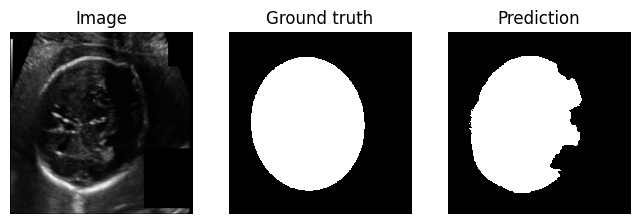

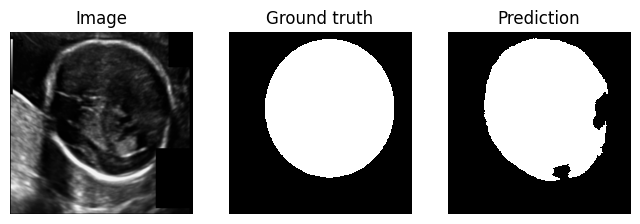

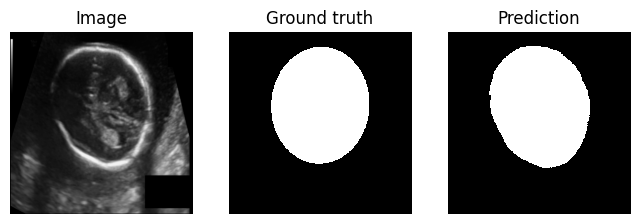

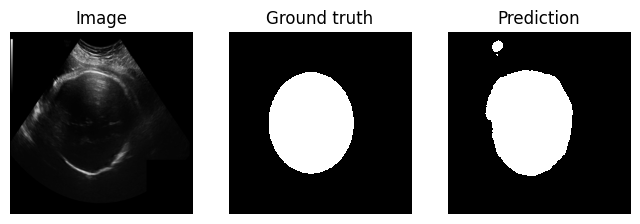

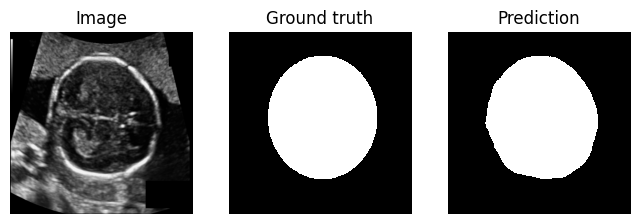

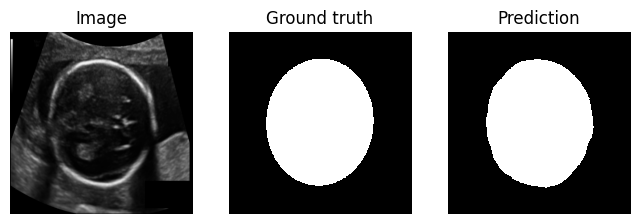

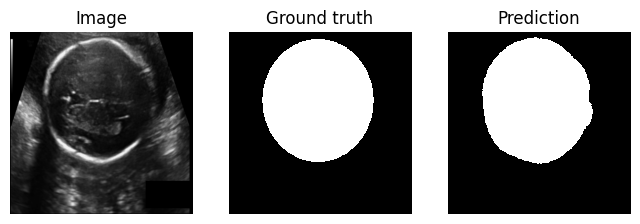

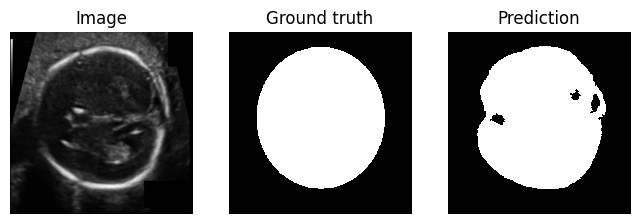

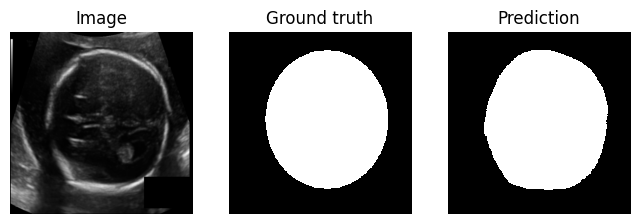

In [ ]:
with torch.no_grad():
  for x, y in testloader_subset:
    image = x.to(DEVICE)
    gt_mask = y.to(DEVICE).unsqueeze(1)
    preds = model(image)
    preds = preds[0]
    preds = (preds > 0.5).float()

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 3, 1)
    x = x.flatten(0, 1)
    plt.imshow(x.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(1-y.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(1-preds.cpu().data.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
torch.Tensor(32, 8, 3).shape

torch.Size([32, 8, 3])

In [ ]:
torch.Tensor(32, 8, 3)

tensor([[[1.1265e+06, 4.5825e-41, 1.1265e+06],
         [4.5825e-41, 1.8393e-34, 0.0000e+00],
         [1.8393e-34, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.7919e+17, 4.5824e-41, 2.7920e+17],
         [4.5824e-41, 1.5414e-44, 5.3021e+25],
         [0.0000e+00, 0.0000e+00, 1.1210e-44],
         [0.0000e+00, 0.0000e+00, 4.5824e-41]],

        [[2.0337e-38, 0.0000e+00,        nan],
         [       nan, 0.0000e+00, 0.0000e+00],
         [       nan,        nan, 2.7921e+17],
         [4.5824e-41, 1.4013e-45, 1.1866e+27],
         [1.0089e-43, 0.0000e+00, 9.8091e-45],
         [0.0000e+00, 9.3686e+16, 4.5824e-41],
         [2.0338e-38, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.4013e-45, 0.0000e+00]],

        [[1.4013e-45, 0.0000e+00, 2.7921e+17],
         [4.5824e-41, 1.4013e-45, 2.1586e+29],
         [2.0179e-43, 0.0000e+00, 4.2039e-45],
         [0.0000e+00, 9.3686e+16, 4.5824e-41],
         [2.0338e-38, 0.0000e+00, 0.0000e+00],
         